In this notebook I gave a try to detectron2 to tarin a model to detect ships in an image. I encountered lots of issues along the way but finally was able to train a model. This is only a demo notebook to get some acquaintance and understanding of the working of detectron2. I have used faster_rcnn_R_50_FPN_3x model here, you can use any model from their model_zoo. And you can also train a model without needing to add any custom mapper. Here I added a custom mapper because number of training images is less. 

# Imports

In [19]:
import os
import json
from tqdm import tqdm
from pathlib import Path


import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import numpy as np
import torch

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.structures.boxes import BoxMode
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

In [2]:
train_dir = 'train'
test_dir = 'test'

In [3]:
train_files = os.listdir(train_dir)
print("Train Files:",len(train_files))

test_files = os.listdir(test_dir)
print("Test Files:",len(test_files))


Train Files: 255
Test Files: 386


To make data manipulation easy I have to make a dataframe with all the data.

In [4]:
with open(f'{train_dir}/metadata.jsonl', 'r') as json_file:
    json_list = list(json_file)

file_name = []
bboxes = []
categories = []
for json_str in json_list:
    result = json.loads(json_str)
#     print(f"result: {result}")
    file_name.append(result['file_name'])
    bboxes.append(result['objects']['bbox'])
    categories.append(result['objects']['categories'])
    
    
df_train = pd.DataFrame([file_name,bboxes,categories]).T
df_train.columns = ['image_id','bbox','category']
df_train = df_train.explode(column=['bbox','category']).reset_index(drop=True)


def create_dataframe_from_jsonl(jsonl_file):
    file_name = []
    bboxes = []
    categories = []
    
    with open(jsonl_file, 'r') as json_file:
        json_list = list(json_file)
        
    for json_str in json_list:
        result = json.loads(json_str)
        file_name.append(result['file_name'])
        bboxes.append(result['objects']['bbox'])
        categories.append(result['objects']['categories'])

    df_train = pd.DataFrame([file_name, bboxes, categories]).T
    df_train.columns = ['image_id', 'bbox', 'category']
    df_train = df_train.explode(column=['bbox', 'category']).reset_index(drop=True)
    
    return df_train

I removed two images and their metadata because of their dimensions.

In [5]:
remove = ['15.png', '133.png']

# Remove rows with matching image IDs
df_train = df_train[~df_train['image_id'].isin(remove)]

In [6]:
df_train.isna().sum()

image_id    0
bbox        0
category    0
dtype: int64

The below two cells adds two columns namely, img_height and img_width, which is required for making dataset dictionary in detectron2.

In [7]:
%%time 
### Get file height and width
img_height = []
img_width = []
image_id = []
all_files = df_train.image_id.unique().tolist()
for f in all_files:
    img = cv2.imread(f'{train_dir}/{f}')
    #image = cv2.resize(img, (1024, 1024))
    img_height.append(img.shape[0])
    img_width.append(img.shape[1])
    image_id.append(f)

CPU times: total: 6.84 s
Wall time: 31 s


In [8]:
tmp = pd.DataFrame([image_id, img_height, img_width]).T
tmp.columns = ['image_id','height','width']
df = df_train.merge(tmp,on='image_id',how='left')

del tmp
# df_train[['file','bbox']].groupby('file').agg({'bbox': lambda x: x.tolist()}).reset_index()
df[['image_id', 'height', 'width', 'bbox']]

,image_id,height,width,bbox
0,0.png,4912,7360,"[6690, 3599, 7164, 3850]"
1,0.png,4912,7360,"[6772, 3386, 7039, 3546]"
2,0.png,4912,7360,"[6705, 3291, 7060, 3485]"
3,0.png,4912,7360,"[6230, 3442, 6597, 3647]"
4,0.png,4912,7360,"[5501, 790, 5552, 868]"
...,...,...,...,...
19582,255.png,3727,6573,"[4766, 3332, 4776, 3366]"
19583,255.png,3727,6573,"[4754, 3336, 4768, 3363]"
19584,255.png,3727,6573,"[6067, 2428, 6121, 2458]"
19585,255.png,3727,6573,"[6031, 1766, 6068, 1789]"


In [9]:
image_ids = df['image_id'].unique()
valid_ids = image_ids[200:]
train_ids = image_ids[:200]

In [10]:
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]

In [11]:
valid_df.shape, train_df.shape


((2777, 5), (16810, 5))

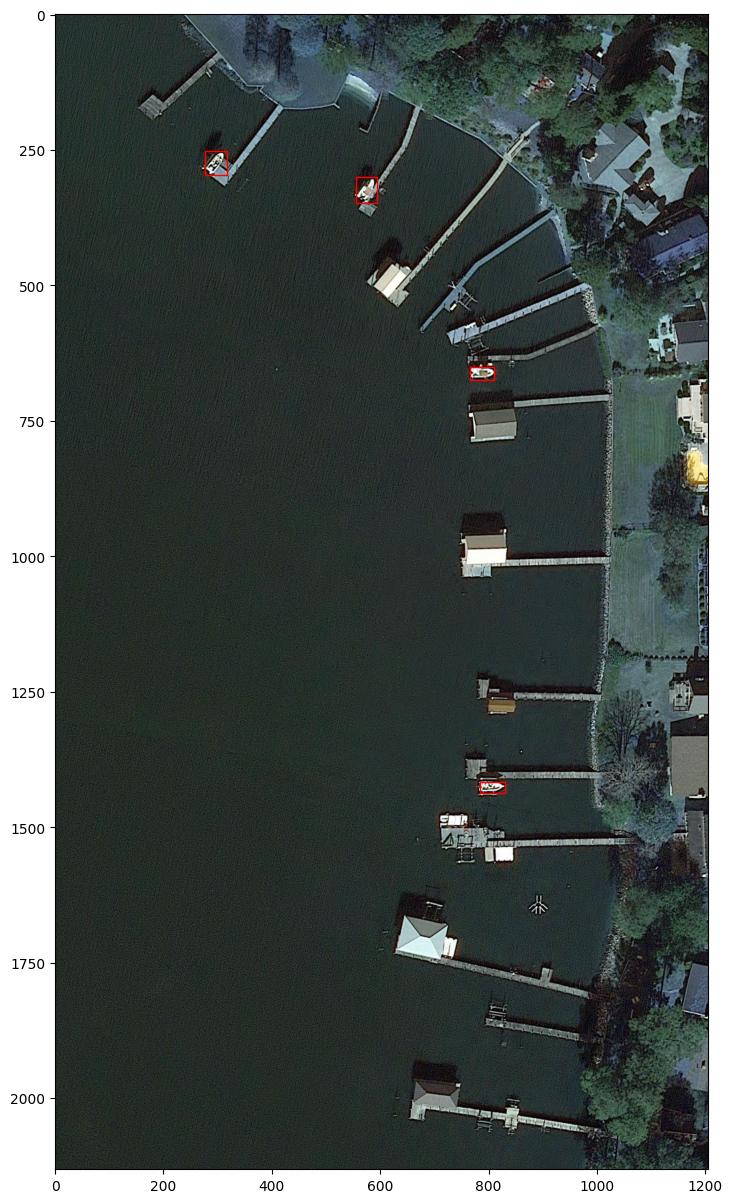

In [12]:
def display_img(f):
# DOTA annotation format is here - https://captain-whu.github.io/DOTA/dataset.html
    img_path = os.path.join(f'{train_dir}/{f}')
    img = cv2.imread(img_path)

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img);
    bboxes = train_df[train_df.image_id==f]['bbox'].tolist()

    for b in bboxes:    
#         print(b)
        rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1], linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

display_img('10.png')

In [13]:
def get_ship_dicts(rootdir, df, category_id):
    df = df
    df.loc[:, 'category_id'] = category_id
    
    dataset_dicts = []
    for idx, image_id in enumerate(df['image_id'].unique()):
        filename = str(Path(rootdir)/f"{image_id}")
        image = cv2.imread(filename)
        height, width, _ = image.shape
        record = {}
        record["file_name"] = filename
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width

        objs = []
        for bbox in df[df['image_id']==image_id]['bbox'].tolist():
            x_min, y_min, x_max, y_max = bbox
            obj= {
                'bbox': [x_min, y_min, x_max, y_max],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': category_id,
                'iscrowd': 0
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

In [14]:
rootdir = "train"
data = get_ship_dicts(rootdir, train_df, 0)

C:\Users\vaibh\AppData\Local\Temp\ipykernel_23024\3128342342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category_id'] = category_id


In [15]:
DatasetCatalog.register('ship_detection', lambda: get_ship_dicts(rootdir, train_df, 0))
ship_data = DatasetCatalog.get('ship_detection')
ship_data_metadata = MetadataCatalog.get('ship_detection')

C:\Users\vaibh\AppData\Local\Temp\ipykernel_23024\3128342342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category_id'] = category_id


In this custom mapper i have resized images to (720, 720) and applied randomflip to make it simple. You can add more transforms. If encounterd any issues with custom_mapper function, refer to their docs [here](https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html).

In [20]:
def custom_mapper(dataset):
    dataset_dict = dataset.copy()  # it will be modified by code below
    print(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    transform_list = [
        T.Resize((720, 720)),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [21]:
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [28]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

torch.cuda.empty_cache()
print('Cleared GPU VRAM')

num_gpu = 1
bs = (num_gpu * 2)

Cleared GPU VRAM


In [33]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('ship_detection',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.MAX_ITER = 200
cfg.SOLVER.BASE_LR = 0.02 * bs / 16
cfg.SOLVER.CHECKPOINT_PERIOD = 10
cfg.MODEL.PIXEL_MEAN = [123.675, 116.28, 103.53]
cfg.MODEL.PIXEL_STD = [58.395, 57.12, 57.375]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1


In [35]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AugTrainer(cfg) 
trainer.resume_or_load(resume=False)

[05/25 11:19:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

C:\Users\vaibh\AppData\Local\Temp\ipykernel_23024\3128342342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category_id'] = category_id


[05/25 11:19:26 d2.data.build]: Removed 0 images with no usable annotations. 200 images left.
[05/25 11:19:26 d2.data.build]: Using training sampler TrainingSampler
[05/25 11:19:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/25 11:19:26 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[05/25 11:19:26 d2.data.common]: Serialized dataset takes 0.58 MiB
WARNING [05/25 11:19:26 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[05/25 11:19:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

In [36]:
trainer.train()

[05/25 11:19:27 d2.engine.train_loop]: Starting training from iteration 0
[05/25 11:20:35 d2.utils.events]:  eta: 0:08:43  iter: 19  total_loss: 2.635  loss_cls: 0.5284  loss_box_reg: 0.006595  loss_rpn_cls: 1.351  loss_rpn_loc: 0.4199  time: 3.0797  last_time: 2.9265  data_time: 0.1441  last_data_time: 0.0012   lr: 0.00023976  max_mem: 0M
[05/25 11:21:37 d2.utils.events]:  eta: 0:07:51  iter: 39  total_loss: 1.47  loss_cls: 0.1508  loss_box_reg: 0.004295  loss_rpn_cls: 0.535  loss_rpn_loc: 0.5289  time: 3.0756  last_time: 3.4671  data_time: 0.0015  last_data_time: 0.0015   lr: 0.00048951  max_mem: 0M
[05/25 11:22:48 d2.utils.events]:  eta: 0:07:00  iter: 59  total_loss: 1.408  loss_cls: 0.1444  loss_box_reg: 0.009063  loss_rpn_cls: 0.5239  loss_rpn_loc: 0.6167  time: 3.1774  last_time: 2.8875  data_time: 0.0015  last_data_time: 0.0012   lr: 0.00073926  max_mem: 0M
[05/25 11:23:51 d2.utils.events]:  eta: 0:05:57  iter: 79  total_loss: 1.388  loss_cls: 0.2522  loss_box_reg: 0.02937  los